In [10]:
%matplotlib inline
import numpy as np
import pyfftw
try:
    from nbodykit.lab import *
    from nbodykit import setup_logging, style
except:
    print('no nbodykit')
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
import warnings
warnings.filterwarnings("ignore")
import pickle
from scipy.stats import poisson
from Corrfunc.theory import *
from astropy.cosmology import FlatLambdaCDM
from scipy.ndimage import convolve
from scipy.interpolate import interp1d
from scipy.stats import norm
import sys
sys.path.append('../')
sys.path.append('../../')

In [11]:
from cosmology_functions import *
from save_matrixA_nooverlap_G2 import load_matrixA_slab
from run_solutions import calc_coadded_qs, calc_reduced_M

In [12]:
sim = 'AbacusSummit_base_c000_ph006'

In [13]:
# parameters about the sim
boxsize = 2000.
k0 = 2*np.pi/boxsize
N0 = 6912
N = 1152
Nfiles = 34

In [14]:
z = 0.5
Rf = 2 # Gaussian smoothing
Nmesh = 400
interp_method = 'cic'

In [15]:
kx, ky, kz = calc_k_grid(boxsize, Nmesh)
k2 = (kx**2 + ky**2 + kz**2).clip(1e-6)
dk = 2*np.pi/boxsize
_kbins = np.linspace(0.5*dk, (Nmesh//2+0.5)*dk, int(Nmesh/2)+1)
_k = (k2**0.5).ravel()
_ind = np.argsort(_k)
_arr = np.searchsorted(_k[_ind], _kbins)
_k = (k2**0.5)
del kx, ky, kz, k2

In [16]:
use_G2 = True
# delta1 bins
bin_edges_d1 = np.linspace(-4, 5, 40+1)
nbins_d1 = len(bin_edges_d1)-1
# G2 bins
nbins_G2 = 1
# saved to which folder
folder = 'matrixA'
if use_G2:
    bin_edges_G2_percentile = np.array([0, 10, 30, 70, 90, 100])
    nbins_G2 = len(bin_edges_G2_percentile)-1
    folder += '_G2'

In [17]:
path = '/mnt/store2/xwu/AbacusSummit/%s/z%s_tilde_operators_nbody/Rf%.3g/' % (sim, str(z), Rf) + folder
outpath = path+'/nooverlap'

In [19]:
# centers of the bins
d1_bins = np.zeros(nbins_d1)
for i in range(nbins_d1):
    x = np.linspace(bin_edges_d1[i], bin_edges_d1[i+1], 10)
    d1_bins[i] = np.sum(x*norm.pdf(x))/np.sum(norm.pdf(x))

# pdf of the bins
allbins_pdf = norm.cdf(bin_edges_d1[1:]) - norm.cdf(bin_edges_d1[:-1])
frac_inbins = norm.cdf(bin_edges_d1[-1]) - norm.cdf(bin_edges_d1[0])

if use_G2:
    d1_bins = d1_bins.reshape(nbins_d1,-1) + np.zeros((nbins_d1, nbins_G2))
    allbins_pdf = allbins_pdf.reshape(-1,1) * \
        (bin_edges_G2_percentile[1:] - bin_edges_G2_percentile[:-1]).reshape(1,-1)

    try:
        G2_bins = np.loadtxt('G2_bins.txt')
    except:
        # load in the delta1 and only use some
        sdelta1 = np.load('/mnt/store2/xwu/AbacusSummit/%s/ic_%d/sdelta1_Rf%.3g.npy' % (sim, N, Rf))
        sigma_sdelta1 = np.std(sdelta1)
        sdelta1 = sdelta1.reshape(-1)/sigma_sdelta1
        # sort the values
        ind = np.argsort(sdelta1)
        sdelta1 = sdelta1[ind]
        arr = np.searchsorted(sdelta1, bin_edges_d1)

        # load in G2 and only use some
        G2 = np.load('/mnt/store2/xwu/AbacusSummit/%s/ic_%d/G2_Rf%.3g.npy' % (sim, N, Rf))
        mean_G2 = np.mean(G2)
        sigma_G2 = np.std(G2)
        print(mean_G2, sigma_G2)
        G2 = (G2.reshape(-1)-mean_G2)/sigma_G2
        G2 = G2[ind]

        # calculate bin centers
        G2_bins = np.zeros((nbins_d1, nbins_G2))
        for m in range(nbins_d1):
            G2_ = G2[arr[m]:arr[m+1]]
            bin_edges_G2 = np.percentile(G2_, bin_edges_G2_percentile)
            for n in range(nbins_G2):
                ii = (G2_ >= bin_edges_G2[n]) & (G2_ < bin_edges_G2[n+1])
                G2_bins[m,n] = np.mean(G2_[ii])

        del sdelta1, G2, G2_
        np.savetxt('G2_bins.txt', G2_bins, fmt='%.3g')

# calculate pdf of bins
allbins_pdf /= allbins_pdf.sum()
allbins_pdf = allbins_pdf.reshape(-1)

0.00016112451 0.00010190707


In [12]:
# load in snapshot
cat = CompaSOHaloCatalog('/mnt/store2/bigsims/AbacusSummit/%s/halos/z%.3f/' % (sim, z),
                         fields=['N', 'x_com', 'r100_com'])

### N > 150 halos

In [13]:
# halo grid
# mass weighted
ii_h = (cat.halos['N'] > 150)
pos_h = cat.halos[ii_h]['x_com']
vals_h = cat.halos[ii_h]['N']
delta_h = ArrayCatalog({'Position': pos_h, 'Value': vals_h}).to_mesh(
    Nmesh=Nmesh, BoxSize=boxsize, resampler=interp_method).compute()
delta_h = delta_h/np.mean(delta_h)-1.
deltak_h = pyfftw.interfaces.numpy_fft.rfftn(delta_h)

In [14]:
P_shot = boxsize**3/ii_h.sum()
kvec, Pk_h = calc_powerspectrum(deltak_h, boxsize, ind=_ind, arr=_arr, kbins=_kbins)

#### including G2

In [15]:
# coadded M and b
M_tot, b_tot = calc_coadded_qs(outpath, Nmesh, interp_method,
                    direct_load=True, calc_M=True, delta_hs=delta_h)
b_tot = b_tot[0]
M_tot_, D, ii_empty = calc_reduced_M(M_tot)
M_ = M_tot_

In [16]:
M = M_tot
M_ = M_tot_
b = b_tot

f_delta1 = np.dot(D, np.dot(np.linalg.inv(M_), b/np.diag(M)**0.5))
ncell = Nmesh**3
nparticles = 0.03*N0**3*frac_inbins
f_delta1 *= nparticles/ncell
# check the solution
print((allbins_pdf*f_delta1).sum())

1.0229422019286245


Text(0, 0.5, '$(G_2-\\bar{G}_2)/\\sigma(G_2)$')

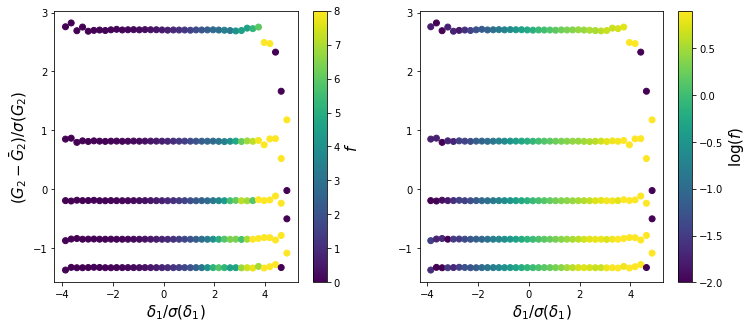

In [17]:
# plot the solution
fig, axes = plt.subplots(figsize=(12,5), nrows=1, ncols=2)

im = axes[0].scatter(d1_bins, G2_bins, c=f_delta1.clip(0), vmin=0, vmax=8)
cbar = plt.colorbar(im, ax=axes[0])
cbar.set_label(r'$f$', fontsize=15)
im = axes[1].scatter(d1_bins, G2_bins, c=np.log10(f_delta1.clip(1e-2, 8)))
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label(r'$\log(f)$', fontsize=15)

axes[0].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[1].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[0].set_ylabel(r'$(G_2-\bar{G}_2)/\sigma(G_2)$', fontsize=15)

(-0.1, 20.0)

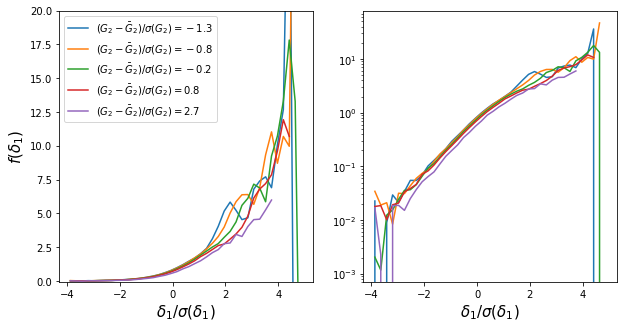

In [25]:
# find a better way of plotting
# for d1 in np.arange(-3,4,1):
#     ii = np.where(np.abs(d1_bins - d1) < 0.2)
#     G2_bins_ = G2_bins[ii].reshape(-1,nbins_G2).mean(axis=0)
#     d1_ = d1_bins[ii][::nbins_G2].mean()
#     f_ = f_delta1.reshape(-1,nbins_G2)[ii].reshape(-1,nbins_G2).mean(axis=0)
#     plt.plot(G2_bins_, f_, label=r'$\delta_1=%.0f$' % d1_)
# plt.legend()
fig, axes = plt.subplots(figsize=(10,5), nrows=1, ncols=2)
for G2 in [-1.3, -0.8, -0.2, 0.8, 2.8]:
    ii = np.where(np.abs(G2_bins - G2) < 0.2)
    d1_bins_ = d1_bins[ii]
    G2_ = G2_bins[ii].mean()
    f_ = f_delta1.reshape(-1,nbins_G2)[ii]
    axes[0].plot(d1_bins_, f_, label=r'$(G_2 - \bar{G}_2)/\sigma(G_2)=%.1f$' % G2_)
    axes[1].plot(d1_bins_, f_)
axes[0].legend()
axes[0].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[1].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[0].set_ylabel(r'$f(\delta_1)$', fontsize=15)
axes[1].set_yscale('log')
axes[0].set_ylim(-0.1, 20)

In [23]:
# check how this works...
delta_model = np.zeros((Nmesh, Nmesh, Nmesh))
for i in range(Nfiles):
    A, ind_slab = load_matrixA_slab(i, outpath, Nmesh, interp_method, direct_load=True)
    delta_model[ind_slab] += np.dot(f_delta1, A).reshape(-1,Nmesh,Nmesh)
delta_model = delta_model/(nparticles/ncell) - 1.
print(np.mean(delta_model))
deltak_model = pyfftw.interfaces.numpy_fft.rfftn(delta_model)

0.01795281188884487


In [24]:
kvec, Pk_model = calc_powerspectrum(deltak_model, boxsize, ind=_ind, arr=_arr, kbins=_kbins)
Pk_res = calc_powerspectrum(deltak_h-deltak_model, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]
Pk_res_h = calc_powerspectrum(deltak_h-deltak_model, boxsize, grid2=deltak_h, ind=_ind, arr=_arr, kbins=_kbins)[1]

Text(0.5, 0, '$k$')

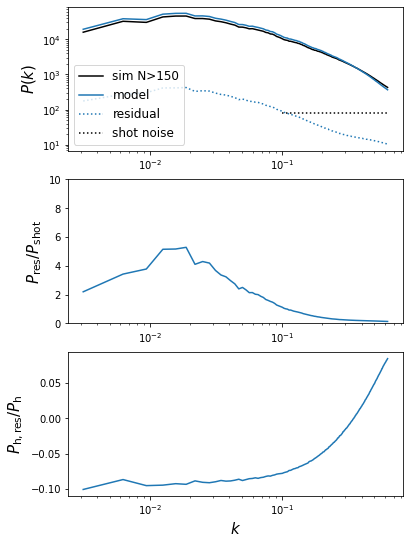

In [25]:
plt.figure(figsize=(6,9))
plt.subplot(311)
plt.loglog(kvec, Pk_h, 'k', label='sim N>150')
plt.loglog(kvec, Pk_model, label='model')
plt.loglog(kvec, Pk_res, 'tab:blue', linestyle=':', label='residual')
plt.loglog([0.1, kvec[-1]], [P_shot, P_shot], 'k:', label='shot noise')
plt.ylabel(r'$P(k)$', fontsize=15)
plt.legend(fontsize=12)
plt.subplot(312)
plt.semilogx(kvec, Pk_res/P_shot)
plt.ylim(0, 10)
plt.ylabel(r'$P_{\rm res}/P_{\rm shot}$', fontsize=15)
plt.subplot(313)
plt.semilogx(kvec, Pk_res_h/Pk_h)
plt.ylabel(r'$P_{\rm h, res}/P_{\rm h}$', fontsize=15)
plt.xlabel(r'$k$', fontsize=15)

In [26]:
# dividing into the uncorrelated and correlated parts
Pk_model = calc_powerspectrum(deltak_model, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]
Pk_h_model = calc_powerspectrum(deltak_model, boxsize, grid2=deltak_h, ind=_ind, arr=_arr, kbins=_kbins)[1]
Pk_alpha = Pk_h_model**2/Pk_h
Pk_eps = Pk_model - Pk_alpha

Text(0.5, 0, '$k$')

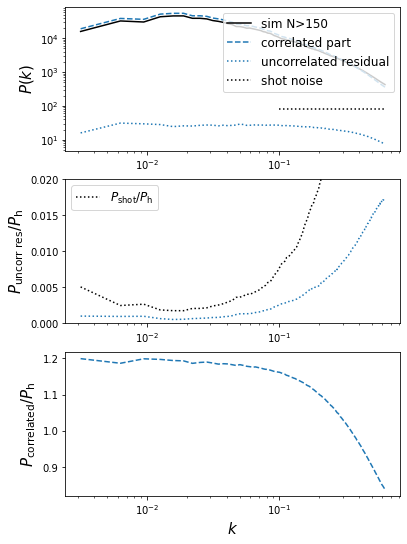

In [27]:
plt.figure(figsize=(6,9))
plt.subplot(311)
plt.loglog(kvec, Pk_h, 'k', label='sim N>150')
plt.loglog(kvec, Pk_alpha, '--', label='correlated part')
plt.loglog(kvec, Pk_eps, 'tab:blue', linestyle=':', label='uncorrelated residual')
plt.loglog([0.1, kvec[-1]], [P_shot, P_shot], 'k:', label='shot noise')
plt.ylabel(r'$P(k)$', fontsize=15)
plt.legend(fontsize=12, loc=1)
plt.subplot(312)
plt.semilogx(kvec, Pk_eps/Pk_h, ':')
plt.plot(kvec, P_shot/Pk_h, 'k:', label=r'$P_{\rm shot}/P_{\rm h}$')
plt.legend(fontsize=12)
plt.ylim(0, 0.02)
plt.ylabel(r'$P_{\rm uncorr\ res}/P_{\rm h}$', fontsize=15)
plt.subplot(313)
plt.semilogx(kvec, Pk_alpha/Pk_h, '--')
plt.ylabel(r'$P_{\rm correlated}/P_{\rm h}$', fontsize=15)
plt.xlabel(r'$k$', fontsize=15)

##### examinations of the matrix M

In [28]:
ii_empty

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [29]:
np.linalg.cond(M), np.linalg.cond(M_)

(69355211.27498123, 467.00018084695256)

In [30]:
np.linalg.eigvals(M_)

array([34.43765613, 14.28285916, 10.57475222,  7.13421409,  6.11842029,
        5.47316151,  4.93437589,  4.32174653,  3.9060743 ,  3.40927634,
        3.16088072,  2.72541963,  2.60702228,  2.5645696 ,  2.39825999,
        2.19488588,  2.15882756,  2.0595325 ,  1.90935662,  1.74820426,
        1.70945001,  1.62785218,  1.48833706,  1.40063287,  1.38148129,
        1.34348669,  1.27457065,  1.21951301,  1.15441469,  1.14746348,
        1.12404668,  1.09237924,  1.05864024,  0.96851295,  0.96218314,
        0.93614104,  0.92534027,  0.91289112,  0.87877946,  0.83601243,
        0.83372271,  0.82358275,  0.81612611,  0.81052858,  0.75646075,
        0.7523301 ,  0.73756608,  0.73185077,  0.72542373,  0.70393357,
        0.69920512,  0.68939959,  0.6844053 ,  0.67242433,  0.66575272,
        0.65678832,  0.64887721,  0.64620958,  0.63864504,  0.63200244,
        0.62971278,  0.61930907,  0.6036517 ,  0.61388518,  0.61053617,
        0.60221012,  0.59044121,  0.58585862,  0.58124402,  0.57

### other halo mass cuts

In [26]:
Nthress = [150, 500, 1000, 3000]

In [27]:
delta_hs = [None]*len(Nthress)
for i in range(len(Nthress)):
    Nthres = Nthress[i]
    ii_h = (cat.halos['N'] > Nthres)
    delta_h = ArrayCatalog({'Position': cat.halos[ii_h]['x_com'], 'Value': cat.halos[ii_h]['N']}).to_mesh(
        Nmesh=Nmesh, BoxSize=boxsize, resampler=interp_method).compute()
    delta_h = delta_h/np.mean(delta_h)-1.
    delta_hs[i] = delta_h

In [28]:
deltak_hs = [pyfftw.interfaces.numpy_fft.rfftn(delta_h) for delta_h in delta_hs]

In [29]:
ncell = Nmesh**3

M, bs = calc_coadded_qs(outpath, Nmesh, interp_method,
                direct_load=True, calc_M=True, delta_hs=delta_hs)
M_, D, ii_empty = calc_reduced_M(M)

f_delta1s = [None]*len(Nthress)
for i in range(len(Nthress)):
    b = bs[i]
    f_delta1 = np.dot(D, np.dot(np.linalg.inv(M_), b/np.diag(M)**0.5)) * nparticles/ncell
    # check the solution
    print(Nthress[i], (allbins_pdf*f_delta1).sum())
    f_delta1s[i] = f_delta1

150 1.0229422019286245
500 1.025599124393048
1000 1.0263956538385952
3000 1.02632326156406


Text(0, 0.5, '$(G_2 - \\bar{G}_2)/\\sigma(G_2)$')

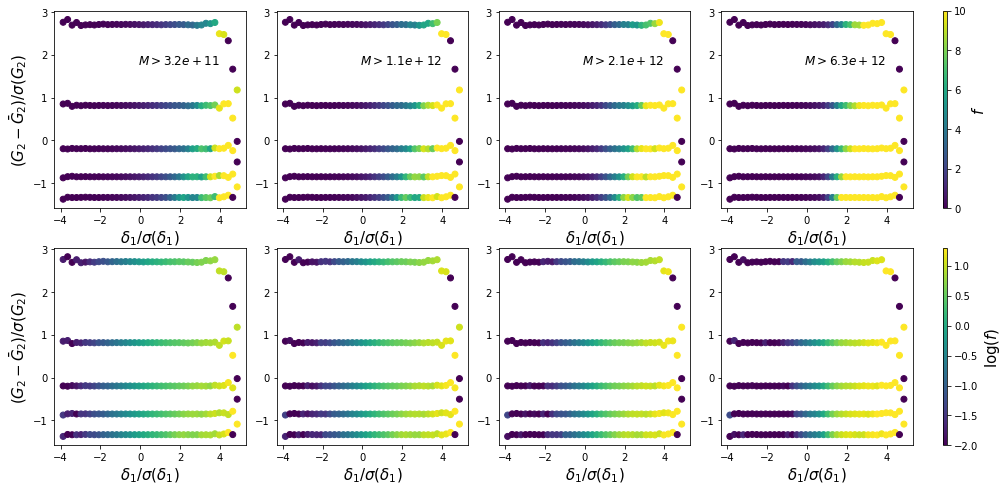

In [38]:
# plot the solution
fig, axes = plt.subplots(figsize=(16,8), nrows=2, ncols=5, gridspec_kw={'width_ratios': [1,1,1,1,0.02]})

for i in range(len(Nthress)):
    f_delta1 = f_delta1s[i]
    Nthres = Nthress[i]
    im0 = axes[0][i].scatter(d1_bins, G2_bins, c=f_delta1.clip(0), vmin=0, vmax=10)
    im1 = axes[1][i].scatter(d1_bins, G2_bins, c=np.log10(f_delta1.clip(1e-2, 20)))
    axes[0][i].text(4, 2, r'$M>%.2g$' % (Nthres*cat.header['ParticleMassHMsun']),
                    horizontalalignment='right', verticalalignment='top', fontsize=12)
    axes[0][i].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
    axes[1][i].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
cbar = plt.colorbar(im0, cax=axes[0][-1])
cbar.set_label(r'$f$', fontsize=15)
cbar = plt.colorbar(im1, cax=axes[1][-1])
cbar.set_label(r'$\log(f)$', fontsize=15)
axes[0][0].set_ylabel(r'$(G_2 - \bar{G}_2)/\sigma(G_2)$', fontsize=15)
axes[1][0].set_ylabel(r'$(G_2 - \bar{G}_2)/\sigma(G_2)$', fontsize=15)

Text(0, 0.5, '$f(\\delta_1)$')

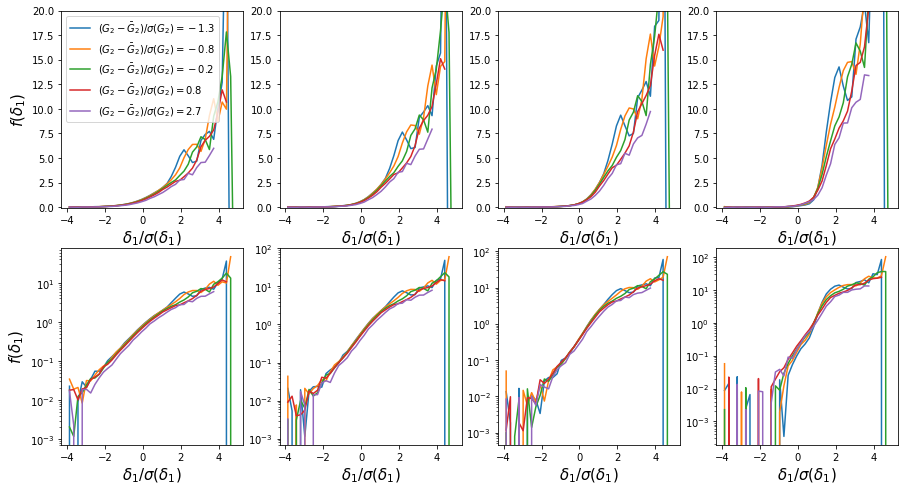

In [37]:
# another way of plotting
fig, axes = plt.subplots(figsize=(15,8), nrows=2, ncols=4)
for i in range(len(Nthress)):
    f_delta1 = f_delta1s[i]
    Nthres = Nthress[i]
    for G2 in [-1.3, -0.8, -0.2, 0.8, 2.8]:
        ii = np.where(np.abs(G2_bins - G2) < 0.2)
        d1_bins_ = d1_bins[ii]
        G2_ = G2_bins[ii].mean()
        f_ = f_delta1.reshape(-1,nbins_G2)[ii]
        axes[0][i].plot(d1_bins_, f_, label=r'$(G_2 - \bar{G}_2)/\sigma(G_2)=%.1f$' % G2_)
        axes[1][i].semilogy(d1_bins_, f_)
    axes[0][i].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
    axes[1][i].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
    axes[0][i].set_ylim(-0.1, 20)
axes[0][0].legend()
axes[0][0].set_ylabel(r'$f(\delta_1)$', fontsize=15)
axes[1][0].set_ylabel(r'$f(\delta_1)$', fontsize=15)

Text(0, 0.5, '$f(G_2)$')

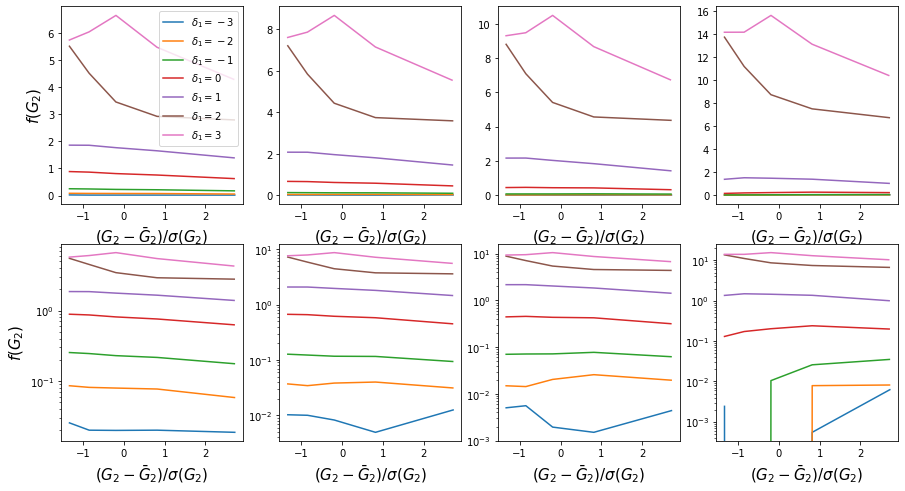

In [41]:
# another way of plotting
fig, axes = plt.subplots(figsize=(15,8), nrows=2, ncols=4)
for i in range(len(Nthress)):
    f_delta1 = f_delta1s[i]
    Nthres = Nthress[i]
    for d1 in np.arange(-3,4,1):
        ii = np.where(np.abs(d1_bins - d1) < 0.2)
        G2_bins_ = G2_bins[ii].reshape(-1,nbins_G2).mean(axis=0)
        d1_ = d1_bins[ii][::nbins_G2].mean()
        f_ = f_delta1.reshape(-1,nbins_G2)[ii].reshape(-1,nbins_G2).mean(axis=0)
        axes[0][i].plot(G2_bins_, f_, label=r'$\delta_1=%.0f$' % d1_)
        axes[1][i].semilogy(G2_bins_, f_)
    axes[0][i].set_xlabel(r'$(G_2 - \bar{G}_2)/\sigma(G_2)$', fontsize=15)
    axes[1][i].set_xlabel(r'$(G_2 - \bar{G}_2)/\sigma(G_2)$', fontsize=15)
#     axes[0][i].set_ylim(-0.1, 20)
axes[0][0].legend()
axes[0][0].set_ylabel(r'$f(G_2)$', fontsize=15)
axes[1][0].set_ylabel(r'$f(G_2)$', fontsize=15)

Text(0, 0.5, '$f$')

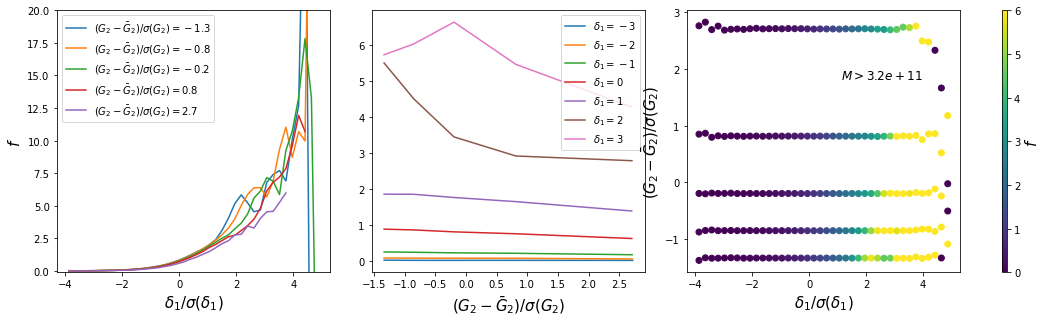

In [45]:
# N > 150
i = 0
f_delta1 = f_delta1s[i]
Nthres = Nthress[i]

fig, axes = plt.subplots(figsize=(15,4), nrows=1, ncols=4, gridspec_kw={'width_ratios': [1,1,1,0.02]})
fig.subplots_adjust(top=0.99, bottom=0.08, left=0.07, right=0.95)

for G2 in [-1.3, -0.8, -0.2, 0.8, 2.8]:
    ii = np.where(np.abs(G2_bins - G2) < 0.2)
    d1_bins_ = d1_bins[ii]
    G2_ = G2_bins[ii].mean()
    f_ = f_delta1.reshape(-1,nbins_G2)[ii]
    axes[0].plot(d1_bins_, f_, label=r'$(G_2 - \bar{G}_2)/\sigma(G_2)=%.1f$' % G2_)
axes[0].legend()

for d1 in np.arange(-3,4,1):
    ii = np.where(np.abs(d1_bins - d1) < 0.2)
    G2_bins_ = G2_bins[ii].reshape(-1,nbins_G2).mean(axis=0)
    d1_ = d1_bins[ii][::nbins_G2].mean()
    f_ = f_delta1.reshape(-1,nbins_G2)[ii].reshape(-1,nbins_G2).mean(axis=0)
    axes[1].plot(G2_bins_, f_, label=r'$\delta_1=%.0f$' % d1_)
axes[1].legend()

im = axes[-2].scatter(d1_bins, G2_bins, c=f_delta1.clip(0), vmin=0, vmax=6)
cbar = plt.colorbar(im, cax=axes[-1])
cbar.set_label(r'$f$', fontsize=15)

axes[0].set_ylim(-0.1, 20)
axes[-2].text(4, 2, r'$M>%.2g$' % (Nthres*cat.header['ParticleMassHMsun']),
            horizontalalignment='right', verticalalignment='top', fontsize=12)
axes[0].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[1].set_xlabel(r'$(G_2 - \bar{G}_2)/\sigma(G_2)$', fontsize=15)
axes[-2].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[-2].set_ylabel(r'$(G_2 - \bar{G}_2)/\sigma(G_2)$', fontsize=15)
axes[0].set_ylabel(r'$f$', fontsize=15)

Text(0, 0.5, '$f$')

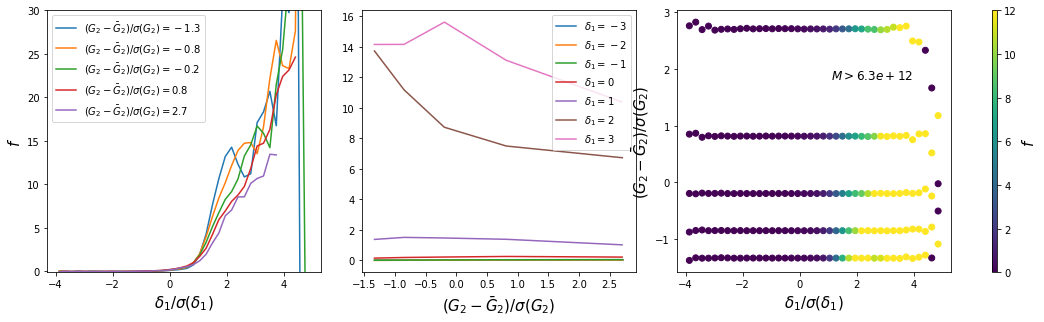

In [48]:
# N > 3000
i = -1
f_delta1 = f_delta1s[i]
Nthres = Nthress[i]

fig, axes = plt.subplots(figsize=(15,4), nrows=1, ncols=4, gridspec_kw={'width_ratios': [1,1,1,0.02]})
fig.subplots_adjust(top=0.99, bottom=0.08, left=0.07, right=0.95)

for G2 in [-1.3, -0.8, -0.2, 0.8, 2.8]:
    ii = np.where(np.abs(G2_bins - G2) < 0.2)
    d1_bins_ = d1_bins[ii]
    G2_ = G2_bins[ii].mean()
    f_ = f_delta1.reshape(-1,nbins_G2)[ii]
    axes[0].plot(d1_bins_, f_, label=r'$(G_2 - \bar{G}_2)/\sigma(G_2)=%.1f$' % G2_)
axes[0].legend()

for d1 in np.arange(-3,4,1):
    ii = np.where(np.abs(d1_bins - d1) < 0.2)
    G2_bins_ = G2_bins[ii].reshape(-1,nbins_G2).mean(axis=0)
    d1_ = d1_bins[ii][::nbins_G2].mean()
    f_ = f_delta1.reshape(-1,nbins_G2)[ii].reshape(-1,nbins_G2).mean(axis=0)
    axes[1].plot(G2_bins_, f_, label=r'$\delta_1=%.0f$' % d1_)
axes[1].legend()

im = axes[-2].scatter(d1_bins, G2_bins, c=f_delta1.clip(0), vmin=0, vmax=12)
cbar = plt.colorbar(im, cax=axes[-1])
cbar.set_label(r'$f$', fontsize=15)

axes[0].set_ylim(-0.1, 30)
axes[-2].text(4, 2, r'$M>%.2g$' % (Nthres*cat.header['ParticleMassHMsun']),
            horizontalalignment='right', verticalalignment='top', fontsize=12)
axes[0].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[1].set_xlabel(r'$(G_2 - \bar{G}_2)/\sigma(G_2)$', fontsize=15)
axes[-2].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[-2].set_ylabel(r'$(G_2 - \bar{G}_2)/\sigma(G_2)$', fontsize=15)
axes[0].set_ylabel(r'$f$', fontsize=15)

In [36]:
# check how this works...
deltak_models = [None]*len(Nthress)
for j in range(len(Nthress)):
    deltak_models[j] = np.zeros((Nmesh, Nmesh, Nmesh))

for i in range(Nfiles):
    A, ind_slab = load_matrixA_slab(i, outpath, Nmesh, interp_method, direct_load=True)
    for j in range(len(Nthress)):
        deltak_models[j][ind_slab] += np.dot(f_delta1s[j], A).reshape(-1,Nmesh,Nmesh)

for j in range(len(Nthress)):
    deltak_models[j] = deltak_models[j]/(nparticles/ncell) - 1.
    print(np.mean(deltak_models[j]))
    deltak_models[j] = pyfftw.interfaces.numpy_fft.rfftn(deltak_models[j])

0.017952811888844854
0.019993702760107698
0.020624883673818067
0.020041187529611686


Text(0.5, 0, '$k$')

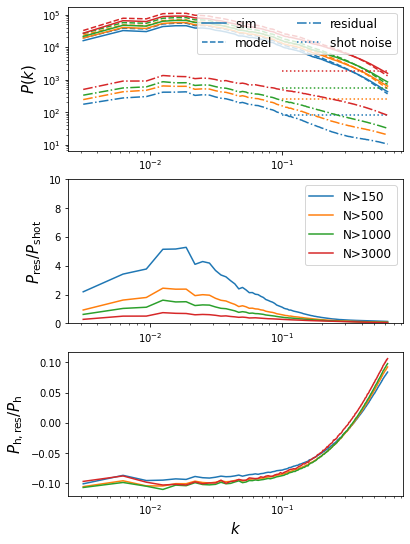

In [38]:
fig, axes = plt.subplots(figsize=(6,9), nrows=3, ncols=1)
for j,c in zip([0, 1, 2, 3], ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']):
    Nthres = Nthress[j]
    deltak_h = deltak_hs[j]
    deltak_model = deltak_models[j]
    kvec, Pk_h = calc_powerspectrum(deltak_h, boxsize, ind=_ind, arr=_arr, kbins=_kbins)
    P_shot = boxsize**3/(cat.halos['N']>Nthres).sum()
    Pk_model = calc_powerspectrum(deltak_model, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]
    Pk_res = calc_powerspectrum(deltak_h-deltak_model, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]
    Pk_res_h = calc_powerspectrum(deltak_h-deltak_model, boxsize, grid2=deltak_h, ind=_ind, arr=_arr, kbins=_kbins)[1]
    axes[0].loglog(kvec, Pk_h, c, label='sim')
    axes[0].loglog(kvec, Pk_model, c, linestyle='--', label='model')
    axes[0].loglog(kvec, Pk_res, c, linestyle='-.', label='residual')
    axes[0].loglog([0.1, kvec[-1]], [P_shot, P_shot], c, linestyle=':', label='shot noise')
    if j == 0:
        axes[0].legend(fontsize=12, loc=1, ncol=2)
    axes[1].semilogx(kvec, Pk_res/P_shot, c, label='N>%d' % Nthres)
    axes[2].semilogx(kvec, Pk_res_h/Pk_h, c)
axes[0].set_ylabel(r'$P(k)$', fontsize=15)
axes[1].legend(fontsize=12, loc=1)
axes[1].set_ylim(0, 10)
axes[1].set_ylabel(r'$P_{\rm res}/P_{\rm shot}$', fontsize=15)
axes[2].set_ylabel(r'$P_{\rm h, res}/P_{\rm h}$', fontsize=15)
axes[2].set_xlabel(r'$k$', fontsize=15)

Text(0.5, 0, '$k$')

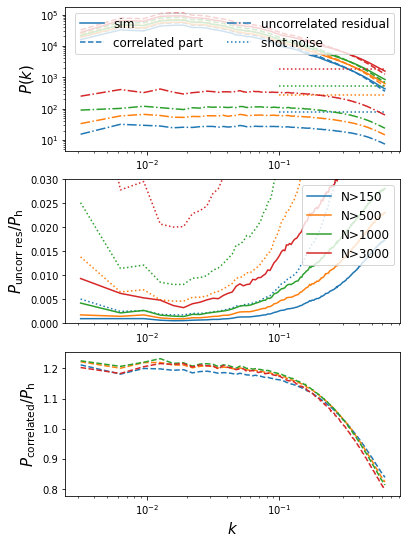

In [40]:
# dividing into the uncorrelated and correlated parts

fig, axes = plt.subplots(figsize=(6,9), nrows=3, ncols=1)
for j,c in zip([0, 1, 2, 3], ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']):
    Nthres = Nthress[j]
    deltak_h = deltak_hs[j]
    deltak_model = deltak_models[j]
    kvec, Pk_h = calc_powerspectrum(deltak_h, boxsize, ind=_ind, arr=_arr, kbins=_kbins)
    P_shot = boxsize**3/(cat.halos['N']>Nthres).sum()
    # the correlated and uncorrelated parts
    Pk_model = calc_powerspectrum(deltak_model, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]
    Pk_h_model = calc_powerspectrum(deltak_model, boxsize, grid2=deltak_h, ind=_ind, arr=_arr, kbins=_kbins)[1]
    Pk_alpha = Pk_h_model**2/Pk_h
    Pk_eps = Pk_model - Pk_alpha
    axes[0].loglog(kvec, Pk_h, c, label='sim')
    axes[0].loglog(kvec, Pk_alpha, c, linestyle='--', label='correlated part')
    axes[0].loglog(kvec, Pk_eps, c, linestyle='-.', label='uncorrelated residual')
    axes[0].loglog([0.1, kvec[-1]], [P_shot, P_shot], c, linestyle=':', label='shot noise')
    if j == 0:
        axes[0].legend(fontsize=12, loc=1, ncol=2)
    axes[1].semilogx(kvec, Pk_eps/Pk_h, c, label='N>%d' % Nthres)
    axes[1].plot(kvec, P_shot/Pk_h, c, linestyle=':')
    axes[2].semilogx(kvec, Pk_alpha/Pk_h, c, linestyle='--')
axes[0].set_ylabel(r'$P(k)$', fontsize=15)
axes[1].legend(fontsize=12, loc=1)
axes[1].set_ylim(0, 0.03)
axes[1].set_ylabel(r'$P_{\rm uncorr\ res}/P_{\rm h}$', fontsize=15)
axes[2].set_ylabel(r'$P_{\rm correlated}/P_{\rm h}$', fontsize=15)
axes[2].set_xlabel(r'$k$', fontsize=15)